In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from os.path import join
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [11]:
path_prefix = '..\AIFFEL\[DATATHON]Brazil_ecommerce'
customers_df = pd.read_csv(join(path_prefix,'olist_customers_dataset.csv'))
geo_df = pd.read_csv(join(path_prefix,'olist_geolocation_dataset.csv'))
orderitem_df = pd.read_csv(join(path_prefix, 'olist_order_items_dataset.csv'), parse_dates=['shipping_limit_date'])
orderpay_df = pd.read_csv(join(path_prefix, 'olist_order_payments_dataset.csv'))
orderreviews_df = pd.read_csv(join(path_prefix, 'olist_order_reviews_dataset.csv'), parse_dates=['review_creation_date'])
orders_df = pd.read_csv(join(path_prefix, 'olist_orders_dataset.csv'), parse_dates=['order_purchase_timestamp'])
products_df = pd.read_csv(join(path_prefix, 'olist_products_dataset.csv'))
sellers_df = pd.read_csv(join(path_prefix, 'olist_sellers_dataset.csv'))
categname_df = pd.read_csv(join(path_prefix, 'product_category_name_translation.csv'))

In [12]:
data = orders_df.merge(customers_df, on="customer_id").merge(orderitem_df, on="order_id").merge(products_df, on="product_id").merge(categname_df, on="product_category_name").merge(orderpay_df, on="order_id").merge(sellers_df, on="seller_id").merge(orderreviews_df, on="order_id")

### 매출 대부분을 발생시킨 소비자의 비율

In [13]:
# 누적 주문량이 가장 많은 소비자들 (in payments)
top_customers = data.groupby("customer_unique_id")["payment_value"].sum().reset_index().sort_values("payment_value", ascending=False)
top_customers.rename(columns={"payment_value":"total_paid"}, inplace=True)

In [14]:
top_customers.head()

,customer_unique_id,total_paid
3724,0a0a92112bd4c708ca5fde585afaa872,109312.64
71647,c402f431464c72e27330a67f7b94d4fb,44048.00
23448,4007669dec559734d6f53e029e360987,36489.24
87507,ef8d54b3797ea4db1d63f0ced6a906e9,30186.00
43213,763c8b1c9c68a0229c42c9fc6f662b93,29099.52


Text(42000, 70, '소비자 40000명(전체의 약 42%)이 \n총 매출의 약 80%를 소비함')

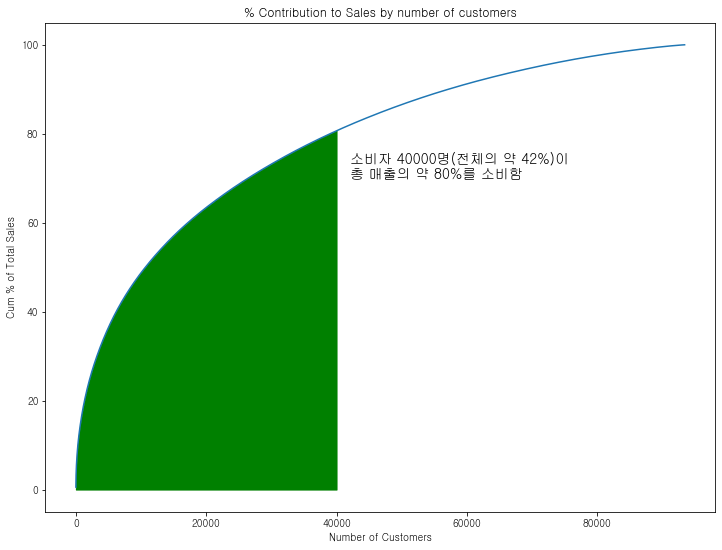

In [21]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.figure(figsize=(12,9))
top_customers["% of Total Sales"] = (top_customers["total_paid"] / top_customers["total_paid"].sum()) * 100
top_customers["Cum % of Total Sales"] = top_customers["% of Total Sales"].cumsum() 
#sns.displot(top_customers["Cum % of Total Sales"])
ax = sns.lineplot(x=range(1,len(top_customers)+1), y="Cum % of Total Sales", data=top_customers)
ax.set_xlabel("Number of Customers")
ax.set_title("% Contribution to Sales by number of customers")
a=np.arange(1,len(top_customers)+1)
b=top_customers["Cum % of Total Sales"]
plt.fill_between(a, b, 0,
                 where = (a >= 0) & (a <= 40000),
                 color = 'g')
ax.text(42000, 70, """소비자 40000명(전체의 약 42%)이 
총 매출의 약 80%를 소비함""", fontsize=14)

### Top 10 소비자의 소비 경향

### 매출 대부분을 발생시킨 셀러의 비율

In [16]:
top_ordersbyvalue_sellers = data.groupby("seller_id")["payment_value"].sum().reset_index().sort_values("payment_value", ascending=False)
top_ordersbyvalue_sellers["% of Total Payments"] = (top_ordersbyvalue_sellers["payment_value"] / top_ordersbyvalue_sellers["payment_value"].sum()) * 100
top_ordersbyvalue_sellers["Cum % of Total Payments"] = top_ordersbyvalue_sellers["% of Total Payments"].cumsum() 

Text(0.5, 1.0, 'TOP 10 sellers by revenue generation')

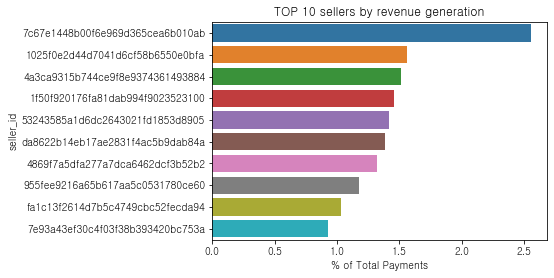

In [17]:
ax = sns.barplot(x="% of Total Payments", y="seller_id", data=top_ordersbyvalue_sellers[:10])
ax.set_title("TOP 10 sellers by revenue generation")

Text(1000, 70, '판매자 540명(총 판매자의 약 17.4 %)이 \n총 매출의 약 80%에 기여함.')

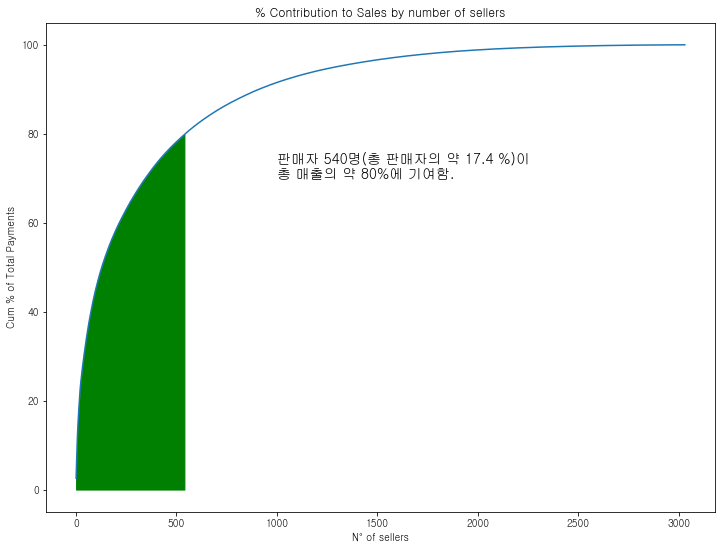

In [18]:
plt.figure(figsize=(12,9))
ax = sns.lineplot(x=range(1,len(top_ordersbyvalue_sellers)+1), y="Cum % of Total Payments", data=top_ordersbyvalue_sellers)
ax.set_xlabel("N° of sellers")
ax.set_title("% Contribution to Sales by number of sellers")
a=np.arange(1,len(top_ordersbyvalue_sellers)+1)
b=top_ordersbyvalue_sellers["Cum % of Total Payments"]
plt.fill_between(a, b, 0,
                 where = (a >= 0) & (a <= 540),
                 color = 'g')
ax.text(1000, 70, """판매자 540명(총 판매자의 약 17.4 %)이 
총 매출의 약 80%에 기여함.""", fontsize=14)

### 상품 평가

In [19]:
# 최고점을 받은 상품들
plt.figure(figsize=(12,12))
reviewsocres = data.groupby("product_category_name_english")["review_score"].agg(["mean", "count"]).sort_values(by="mean",ascending=False)
#ax = sns.barplot(y=bestrated.index, x=bestrated.values)
# Get only products with 30 or more reviews in order to have a more realistic idea about the rating
bestrated = reviewsocres[reviewsocres["count"]>=30][:10]
bestrated

,mean,count
product_category_name_english,,
books_general_interest,4.438503,561
books_imported,4.419355,62
flowers,4.419355,31
costruction_tools_tools,4.415842,101
books_technical,4.375465,269
food_drink,4.324138,290
small_appliances_home_oven_and_coffee,4.320513,78
luggage_accessories,4.295945,1159
fashion_sport,4.258065,31


<Figure size 864x864 with 0 Axes>

In [20]:
# 최하점을 받은 상품들
worstrated = reviewsocres[reviewsocres["count"]>=30].sort_values(by='mean')[:10]
worstrated

,mean,count
product_category_name_english,,
diapers_and_hygiene,3.256410,39
office_furniture,3.526791,1773
fashion_male_clothing,3.548611,144
fixed_telephony,3.672862,269
fashio_female_clothing,3.780000,50
furniture_mattress_and_upholstery,3.804878,41
audio,3.840849,377
furniture_bedroom,3.841270,126
party_supplies,3.847826,46


## RFM

### Recency

df_recency = data.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
df_recency.rename(columns={'order_purchase_timestamp':'LastPurchaseDate'}, inplace=True)


In [22]:
# Calculate recency 
df_recency = data.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
df_recency.rename(columns={"order_purchase_timestamp":"LastPurchaseDate"}, inplace=True)
df_recency["LastPurchaseDate"] = df_recency["LastPurchaseDate"].dt.date
# Get recent invoice date and use it to calculate recency
recent_date = data['order_purchase_timestamp'].dt.date.max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)

### Frequency

In [23]:
frequency_df = data.groupby(['customer_unique_id']).agg({'order_id':'nunique'}).reset_index()
frequency_df.rename(columns={'order_id':'Frequency'}, inplace=True)
frequency_df.head(10)

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
5,0004bd2a26a76fe21f786e4fbd80607f,1
6,00050ab1314c0e55a6ca13cf7181fecf,1
7,00053a61a98854899e70ed204dd4bafe,1
8,0005e1862207bf6ccc02e4228effd9a0,1
9,0005ef4cd20d2893f0d9fbd94d3c0d97,1


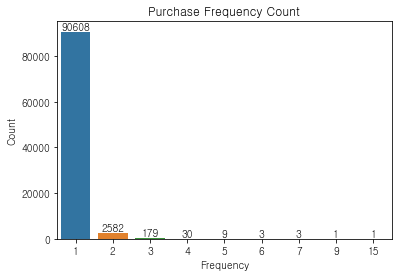

In [24]:
frequency_count = frequency_df.value_counts('Frequency').reset_index()
# frequency_count['Frequency'] /= frequency_count['Frequency'].sum()
frequency_count.rename(columns={0:'Count'}, inplace=True)
# frequency_count.info()
ax = sns.barplot(data=frequency_count, x='Frequency', y='Count')
for i in ax.containers:
    ax.bar_label(i,)
#bar = plt.bar(frequency_count['Frequency'], frequency_count['Percentage'])

# for rect in bar:
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width()/2.0, 
#     height, '%.2f' % height, ha='center', va='bottom', size=12)
plt.title('Purchase Frequency Count')
plt.show()


### Monetary

In [25]:
monetary_df = data.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_unique_id', 'Monetary']
monetary_df.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [26]:
rf_df = df_recency.merge(frequency_df, on='customer_unique_id')
rfm_df = rf_df.merge(monetary_df, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 93416 entries, 0 to 93415
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93416 non-null  object 
 1   Recency             93416 non-null  int64  
 2   Frequency           93416 non-null  int64  
 3   Monetary            93416 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.6+ MB


In [27]:
# Remove zeros from data before log trans
rfm_df[rfm_df.columns[1:]] = rfm_df[rfm_df.columns[1:]].applymap(lambda x: 1 if x ==0 else x)
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93416 entries, 0 to 93415
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93416 non-null  object 
 1   Recency             93416 non-null  int64  
 2   Frequency           93416 non-null  int64  
 3   Monetary            93416 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.6+ MB


In [41]:
# Runnng K Means algo to cluster our data
# Let's check if data is skewed first
def check_skew(df_skew, column):
    plt.figure(figsize=(10, 6))
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

In [47]:
# Perform log transformation
rfm_df_log = rfm_df.copy()
for c in rfm_df.columns[3:4]:
    rfm_df_log[c] = np.log10(rfm_df_log[c])


In [48]:
rfm_df['R_score'] = np.interp(rfm_df_log['Recency'], (rfm_df_log['Recency'].min(), rfm_df_log['Recency'].max()), (100, 1)).round(2)
rfm_df['F_score'] = np.interp(rfm_df_log['Frequency'], (rfm_df_log['Frequency'].min(), rfm_df_log['Frequency'].max()), (1,100))
rfm_df['M_score'] = np.interp(rfm_df_log['Monetary'], (rfm_df_log['Monetary'].min(), rfm_df_log['Monetary'].max()), (1,100))
rfm_df['RFM_score'] = ((rfm_df['R_score'] + rfm_df['F_score'] + rfm_df['M_score'] ) / 3).round(2)
rfm_df['RFM_score']
rfm_df_log['R_score'] = rfm_df['R_score'].copy()
rfm_df_log['F_score'] = rfm_df['F_score'].copy()
rfm_df_log['M_score'] = rfm_df['M_score'].copy()
rfm_df_log['RFM_score'] = rfm_df['RFM_score'].copy()

In [49]:
rfm_df['Class'] = pd.qcut(rfm_df['RFM_score'], q=[0, 0.1, 0.3, 0.6, 1], labels=[4,3,2,1])
rfm_df['Class']

0        1
1        2
2        4
3        3
4        2
        ..
93411    1
93412    2
93413    4
93414    1
93415    4
Name: Class, Length: 93416, dtype: category
Categories (4, int64): [4 < 3 < 2 < 1]

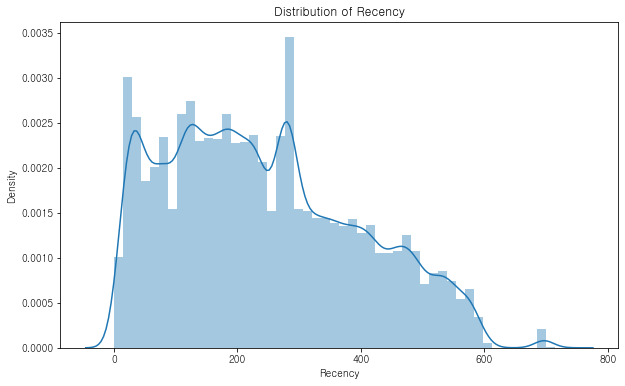

Recency's: Skew: 0.4525680778710665, : SkewtestResult(statistic=53.922639943569486, pvalue=0.0)


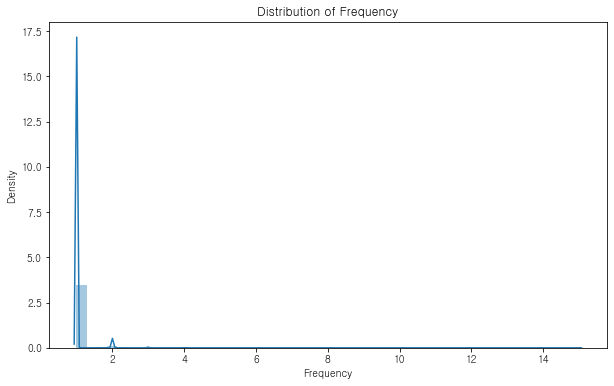

Frequency's: Skew: 10.989248435343244, : SkewtestResult(statistic=335.6659492792071, pvalue=0.0)


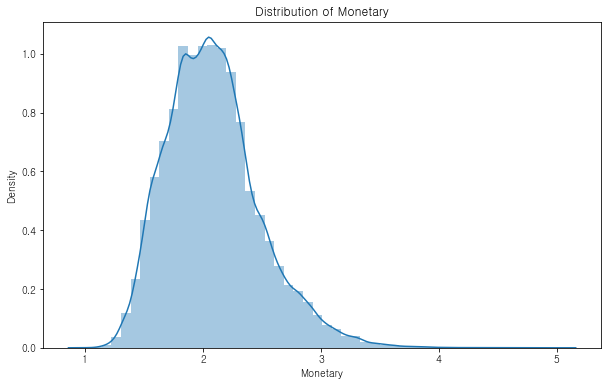

Monetary's: Skew: 0.729494484975128, : SkewtestResult(statistic=81.91848451363079, pvalue=0.0)


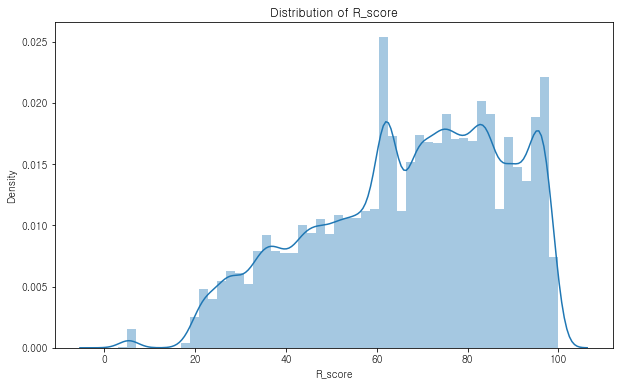

R_score's: Skew: -0.45257867821451087, : SkewtestResult(statistic=-53.92379692244097, pvalue=0.0)


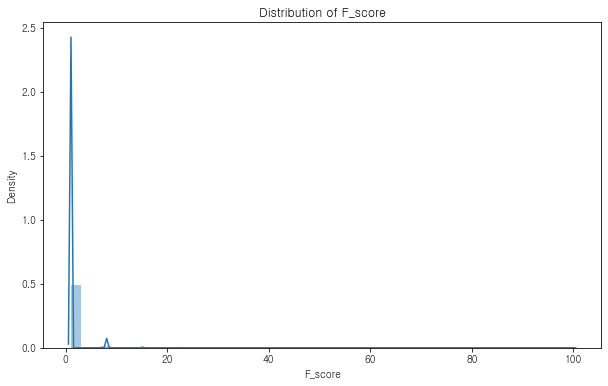

F_score's: Skew: 10.989248435343246, : SkewtestResult(statistic=335.66594927920715, pvalue=0.0)


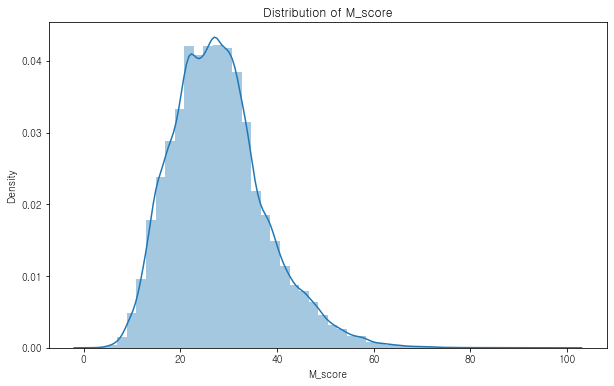

M_score's: Skew: 0.729494484975128, : SkewtestResult(statistic=81.91848451363079, pvalue=0.0)


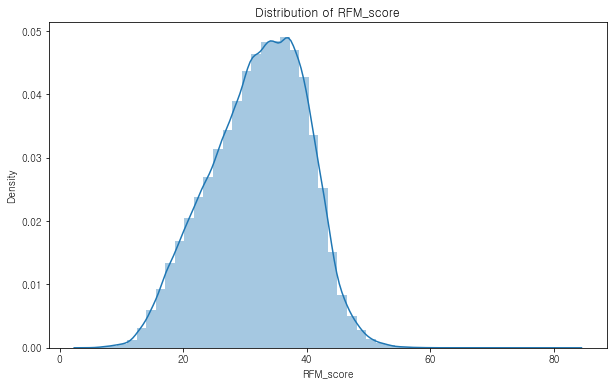

RFM_score's: Skew: -0.2551863087138838, : SkewtestResult(statistic=-31.347211737758848, pvalue=1.0618592374121488e-215)


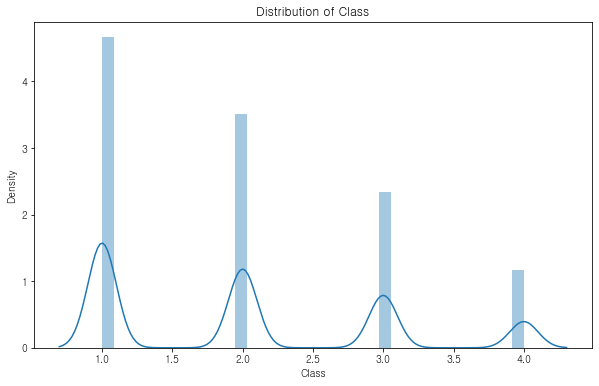

Class's: Skew: 0.5994093493941702, : SkewtestResult(statistic=69.32562766042156, pvalue=0.0)


In [50]:
for col in rfm_df.columns[1:]:
    check_skew(rfm_df_log, col)

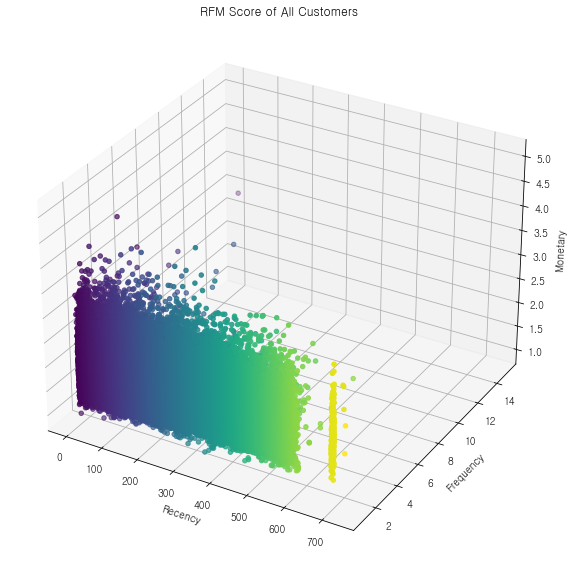

In [51]:
# 필요한 라이브러리를 호출합니다. 
from mpl_toolkits.mplot3d import Axes3D

# 시각화를 위해 필요한 Figure와 ax를 정의합니다. 
fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')

# x축, y축, z축에 각 데이터를 할당합니다. 
x = rfm_df_log['Recency']
y = rfm_df_log['Frequency']
z = rfm_df_log['Monetary']

# x축, y축, z축에 각 레이블을 부여합니다. . 
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

#ax.set_xlim3d(0,)
#ax.set_ylim3d(0, 1000)
#ax.set_zlim3d(0, 1000)

# 산포도 형태의 3차원 시각화를 수행합니다. 
# 이때 색깔은 x축을 기준으로 합니다. 
ax = ax.scatter(x,y,z, c=x)

plt.title('RFM Score of All Customers')
plt.show()

In [ ]:
plt.figure
sns.scatterplot(data=rfm_df, x='R_score', y='M_score', hue='Class')
plt.title('Customer By Class')
plt.show()